# Assignment 3, Part A
Multi-Layer Perceptron (MLP) neural network models developed to classify handwritten digits (0-9)
from the MNIST (Modified National Institute of Standards and Technology) Dataset. Models created
based on unique specifications for eachexperiment. The MLP model will be trained using the
Backpropagation algorithm that implemented using the mini-batch Stochastic Gradient Descent (SGD)
optimization algorithm.

Mini-batch size set to 64. Network trained to 50 epochs with early stopping enabled.

### MNIST (Modified National Institute of Standards and Technology) Dataset
Set of 70,000 small images of digits handwritten by high school students and employees of the US
Census Bureau. Each image is labeled with the digit it represents. The train set contains 60,000 
images, from which you should randomly select 5000 images as the validation set. 

##### Source:
- Data loaded directly using the Keras API: https://keras.io/api/datasets/mnist/ 

##### Input variables:
- 28x28=784 greyscale pixels
    - Pixel intensity: 0 (white) to 255 (black)

##### Output variable: 
- 10 classes representing integer values from 0 to 9


In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve

## Load Data & Display Dataset Information

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
x_train Min: 0
x_train Max: 255
y_train Min: 0
y_train Max: 9
x_train dtype: uint8
y_train dtype: uint8
Training ( 0 ) -  5923 ; Test ( 0 ) -  980
Training ( 1 ) -  6742 ; Test ( 1 ) -  1135
Training ( 2 ) -  5958 ; Test ( 2 ) -  1032
Training ( 3 ) -  6131 ; Test ( 3 ) -  1010
Training ( 4 ) -  5842 ; Test ( 4 ) -  982
Training ( 5 ) -  5421 ; Test ( 5 ) -  892
Training ( 6 ) -  5918 ; Test ( 6 ) -  958
Training ( 7 ) -  6265 ; Test ( 7 ) -  1028
Training ( 8 ) -  5851 ; Test ( 8 ) -  974
Training ( 9 ) -  5949 ; Test ( 9 ) -  1009


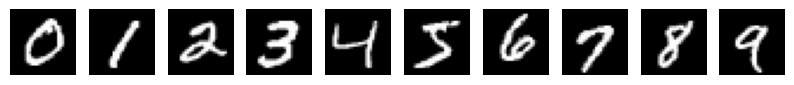

In [3]:
# Load the MNIST dataset using Keras
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Show the shape of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Print the minimum and maximum values of the training data
print("x_train Min:", np.min(x_train))
print("x_train Max:", np.max(x_train))
print("y_train Min:", np.min(y_train))
print("y_train Max:", np.max(y_train))

print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Print the number of samples for each class
for i in range(10):
    print("Training (", i, ") - ", np.sum(y_train == i), "; Test (", i, ") - ", np.sum(y_test == i))

# Display the first training image for each class
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[y_train == i][0], cmap='gray')
    plt.axis('off')

## Data Pre-processing


In [4]:
# Normalize the input data
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train Min:", np.min(x_train))
print("x_train Max:", np.max(x_train))
print("x_train dtype:", x_train.dtype)

x_train Min: 0.0
x_train Max: 1.0
x_train dtype: float64


In [5]:
# Convert the labels to the appropriate datatype for TensorFlow
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

## Data Analysis

In [6]:
def list_maximum_pairs_symmetric_matrix(sym_matrix, num_pairs):
    tmp = sym_matrix.copy()
    tmp = np.triu(tmp, k=1)

    print(f"Top {num_pairs} pairs:")
    for i in range(num_pairs):
        max_idx = np.unravel_index(np.argmax(tmp), tmp.shape)
        print(f"({max_idx[0]}, {max_idx[1]}) => {sym_matrix[max_idx]}")
        tmp[max_idx] = 0

Top 10 pairs:
(4, 9) => 0.8978909301898065
(5, 8) => 0.8688165934976697
(7, 9) => 0.8541372022126612
(3, 5) => 0.8488986033636338
(3, 8) => 0.8179677931758487
(8, 9) => 0.7985014177503245
(2, 8) => 0.7902616532929929
(2, 6) => 0.7696276051784255
(0, 5) => 0.7597062495955851
(5, 9) => 0.7525678937458707


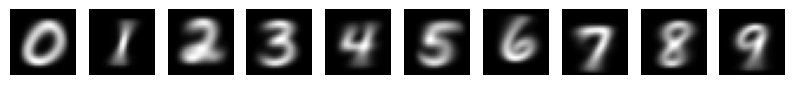

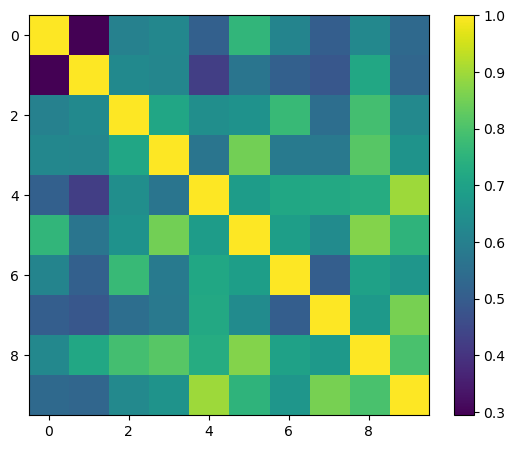

In [7]:
# Average the pixel values for each class
class_means = np.zeros((10, 28, 28))
for i in range(10):
    class_means[i] = np.mean(x_train[y_train == i], axis=0)

# Display the average images
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(class_means[i], cmap='gray')
    plt.axis('off')

# Look at the correlation between the average images of each class
corr = np.corrcoef(class_means.reshape(10, -1))

# Print the top 5 correlated pairs (excluding the diagonal and lower triangle)
list_maximum_pairs_symmetric_matrix(corr, 10)

# Display the correlation matrix as an image
plt.figure(figsize=(5,4))
plt.imshow(corr)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)


## Partition the Dataset into Train & Validation Subsets

In [8]:
# Randomly select 5000 samples from the training data for the training set
np.random.seed(42)
val_size = 5000
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42, stratify=y_train)

# Show the shape of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (55000, 28, 28)
y_train shape: (55000,)
x_val shape: (5000, 28, 28)
y_val shape: (5000,)


## Helper Functions
The following helper functions are inteded to be used througout all experiments.

In [9]:
def plot_learning_curves(history, title):
    numOfEpochs = history.epoch[-1]+1
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

In [10]:
def calculate_tar_at_far(y_true, y_pred, far, show_curve=False):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    
    if show_curve:
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()
    
    return tpr[fpr >= far][0]

In [11]:
# Create an early stopping callback for use across all experiments
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    min_delta=0,
    patience=10,
    restore_best_weights=True
)

In [69]:
def training_wrapper(ex_num, model, n_epochs, batch_size, x_train, y_train, x_val, y_val, cbs=[]):
    print(f"Starting Experiment {ex_num}...")
    print()
    print("**************************************************************************************")
    print("********************************    TRAINING MODEL    ********************************")
    print("**************************************************************************************")
    history = model.fit(
        x_train, 
        y_train, 
        epochs=n_epochs,
        batch_size=batch_size, 
        validation_data=(x_val, y_val), 
        callbacks=cbs
    )

    print()
    print("***************************************************************************************")
    print("******************************    EVALUATING TRAINING    ******************************")
    print("***************************************************************************************")
    print()
    plot_learning_curves(history, f"Experiment {ex_num}")

    return model, history

In [13]:
def evaluation_wrapper(ex_num, model, x_train, y_train, x_test, y_test, far_list=[], plot_roc=False):
    print(f"Starting Evaluation for Experiment {ex_num}...")
    
    y_pred = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    
    print()
    print("**************************************************************************************")
    print("***************************    EVALUATING TRAINED MODEL    ***************************")
    print("**************************************************************************************")
    print()
    train_accuracy = accuracy_score(y_train, np.argmax(model.predict(x_train, verbose=0), axis=1))
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Train Accuracy: {np.round(train_accuracy, 4)}")
    print(f"Test Accuracy: {np.round(test_accuracy, 4)}")
    print()
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    # print()
    # print("Classification Report:")
    # print(classification_report(y_test, y_pred))
    
    print()
    print("***************************************************************************************")
    print("*********************************    EXTRA METRICS    *********************************")
    print("***************************************************************************************")
    print()
    for far in far_list:
        tar_at_far = calculate_tar_at_far(y_test, y_pred, far)
        print(f"TAR @ FAR={far*100}%: {np.round(tar_at_far, 4)*100}%")
    if plot_roc:
        print()
        _ = calculate_tar_at_far(y_test, y_pred, 0.01, show_curve=True)

    print()
    print("Misclassified digits...")
    # Using the confusion matrix, list the top ten most confused pairs of digits
    list_maximum_pairs_symmetric_matrix(conf_matrix, 10)
    
    return y_pred

## Experiment 1
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): zeros
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [14]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='zeros', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='zeros', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='zeros', name='output')
])

optimizer_ex1 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1.compile(optimizer=optimizer_ex1, loss=loss_fn_ex1, metrics=['accuracy'])

model_ex1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 1...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3089 - accuracy: 0.1033 - val_loss: 2.3080 - val_accuracy: 0.1044
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3055 - accuracy: 0.1041 - val_loss: 2.3044 - val_accuracy: 0.0992
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3026 - accuracy: 0.1100 - val_loss: 2.2984 - val_accuracy: 0.1124
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 2.2761 - accuracy: 0.1296 - val_loss: 2.2187 - val_accuracy: 0.2076
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 2.0875 - accuracy: 0.2500 - val_loss: 1.9799 - val_accuracy: 0.2784
Epo

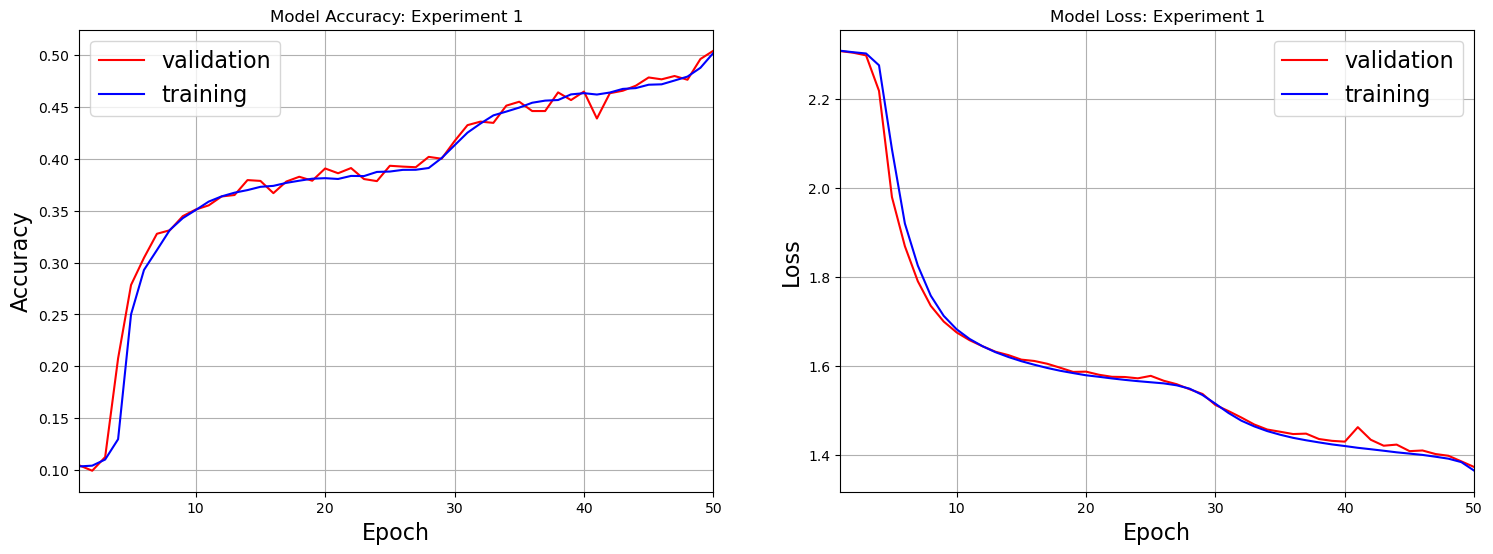

CPU times: total: 16min 3s
Wall time: 1min 25s


In [ ]:
%%time
model_ex1, history_ex1 = training_wrapper(
    ex_num=1,
    model=model_ex1,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [16]:
y_pred_ex1 = evaluation_wrapper(
    ex_num=1,
    model=model_ex1,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.5066
Test Accuracy: 0.5103

Confusion Matrix:
[[ 904    0    2    3    0   45   26    0    0    0]
 [   0 1021    6    4    7    1    0   67    0   29]
 [  12    3  354  251   54   31  292    8    0   27]
 [   4   11  133  479  137   88   32   40    0   86]
 [   0   25   36  172  283    3    7   99    0  357]
 [  24    1  160  231   34  345   73   11    0   13]
 [  46    0  142   33    5   20  708    2    0    2]
 [   0  280    5   38   40    6    1  516    0  142]
 [   8    7  179  472  122   35   63   29    0   59]
 [   1   51    9   48  112    5    5  285    0  493]]

***************************************************************************************
*************

## Experiment 2
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): ones
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [17]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='ones', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='ones', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='ones', name='output')
])

optimizer_ex2 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex2 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex2.compile(optimizer=optimizer_ex2, loss=loss_fn_ex2, metrics=['accuracy'])

model_ex2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 2...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3856 - accuracy: 0.1017 - val_loss: 2.5220 - val_accuracy: 0.0974
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3814 - accuracy: 0.1004 - val_loss: 2.4188 - val_accuracy: 0.0904
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3814 - accuracy: 0.1019 - val_loss: 2.4293 - val_accuracy: 0.1044
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3790 - accuracy: 0.1012 - val_loss: 2.5055 - val_accuracy: 0.1124
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3805 - accuracy: 0.1016 - val_loss: 2.4413 - val_accuracy: 0.0988
Epo

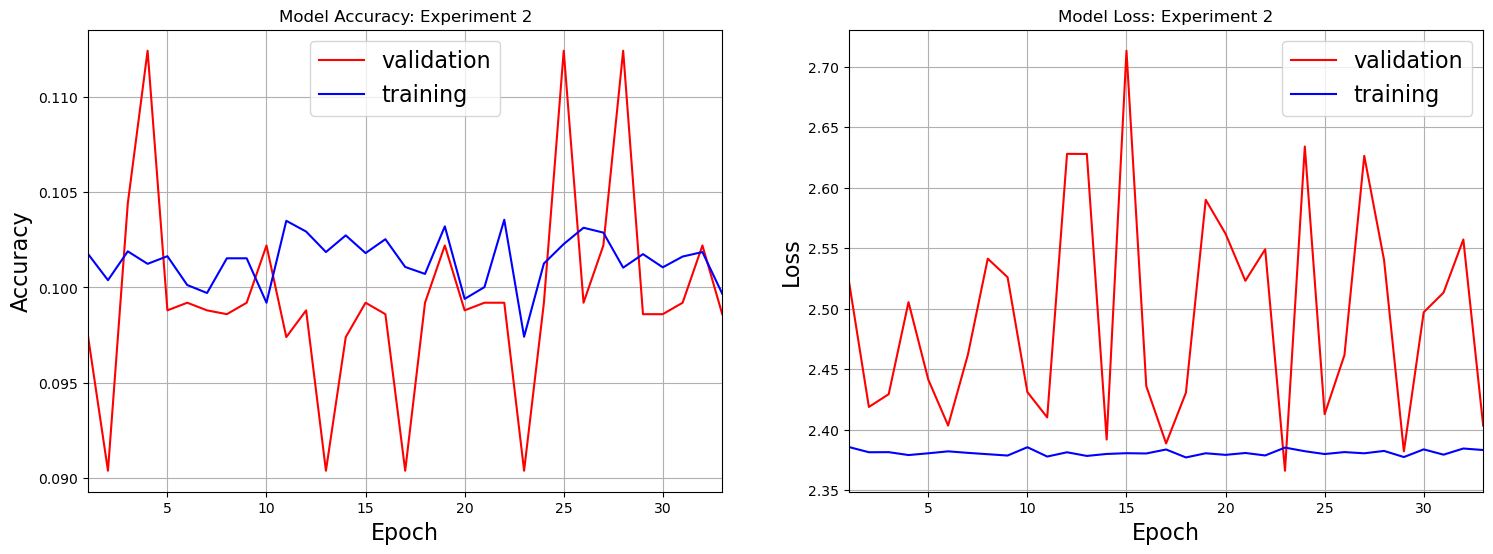

CPU times: total: 8min 57s
Wall time: 46.6 s


In [ ]:
%%time
model_ex2, history_ex2 = training_wrapper(
    ex_num=2,
    model=model_ex2,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [19]:
y_pred_ex2 = evaluation_wrapper(
    ex_num=2,
    model=model_ex2,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 2...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.0903
Test Accuracy: 0.0892

Confusion Matrix:
[[   0    0    0    0    0  980    0    0    0    0]
 [   0    0    0    0    0 1135    0    0    0    0]
 [   0    0    0    0    0 1032    0    0    0    0]
 [   0    0    0    0    0 1010    0    0    0    0]
 [   0    0    0    0    0  982    0    0    0    0]
 [   0    0    0    0    0  892    0    0    0    0]
 [   0    0    0    0    0  958    0    0    0    0]
 [   0    0    0    0    0 1028    0    0    0    0]
 [   0    0    0    0    0  974    0    0    0    0]
 [   0    0    0    0    0 1009    0    0    0    0]]

***************************************************************************************
*************

## Experiment 3
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [20]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex3 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex3 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex3.compile(optimizer=optimizer_ex3, loss=loss_fn_ex3, metrics=['accuracy'])

model_ex3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 3...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 1.7050 - accuracy: 0.4453 - val_loss: 0.8626 - val_accuracy: 0.7346
Epoch 2/50
860/860 [==============================] - 1s 2ms/step - loss: 0.5966 - accuracy: 0.8319 - val_loss: 0.4696 - val_accuracy: 0.8642
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 0.4067 - accuracy: 0.8839 - val_loss: 0.3835 - val_accuracy: 0.8948
Epoch 4/50
860/860 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.8997 - val_loss: 0.3444 - val_accuracy: 0.9022
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 0.3185 - accuracy: 0.9077 - val_loss: 0.3249 - val_accuracy: 0.9060
Epo

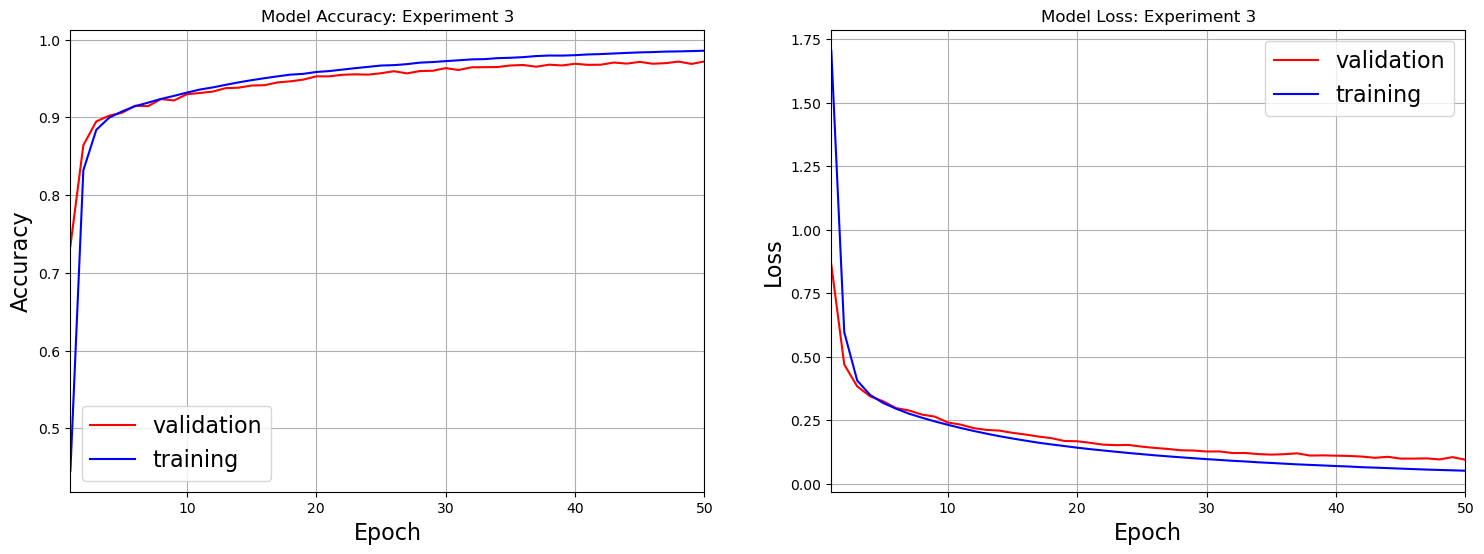

CPU times: total: 12min 40s
Wall time: 1min 4s


In [ ]:
%%time
model_ex3, history_ex3 = training_wrapper(
    ex_num=3,
    model=model_ex3,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [22]:
y_pred_ex3 = evaluation_wrapper(
    ex_num=3,
    model=model_ex3,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 3...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9874
Test Accuracy: 0.9742

Confusion Matrix:
[[ 968    0    1    1    0    4    1    1    2    2]
 [   0 1127    2    1    0    1    2    0    2    0]
 [   6    2 1007    5    1    0    4    4    3    0]
 [   0    0    2  993    0    5    0    4    4    2]
 [   2    0    1    0  948    1    6    3    1   20]
 [   7    1    0   13    2  857    3    1    5    3]
 [   7    3    1    0    3    4  935    0    5    0]
 [   2   12   11    5    0    0    0  984    2   12]
 [   4    0    2    6    3    4    3    2  946    4]
 [   4    4    0    7    9    1    0    4    3  977]]

***************************************************************************************
*************

## Experiment 4
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): tanh
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [23]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='tanh', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex4 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex4 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex4.compile(optimizer=optimizer_ex4, loss=loss_fn_ex4, metrics=['accuracy'])

model_ex4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 4...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 0.4224 - accuracy: 0.8860 - val_loss: 0.2804 - val_accuracy: 0.9170
Epoch 2/50
860/860 [==============================] - 1s 2ms/step - loss: 0.2173 - accuracy: 0.9358 - val_loss: 0.1997 - val_accuracy: 0.9414
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1620 - accuracy: 0.9522 - val_loss: 0.1622 - val_accuracy: 0.9524
Epoch 4/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1286 - accuracy: 0.9627 - val_loss: 0.1376 - val_accuracy: 0.9598
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1062 - accuracy: 0.9688 - val_loss: 0.1234 - val_accuracy: 0.9624
Epo

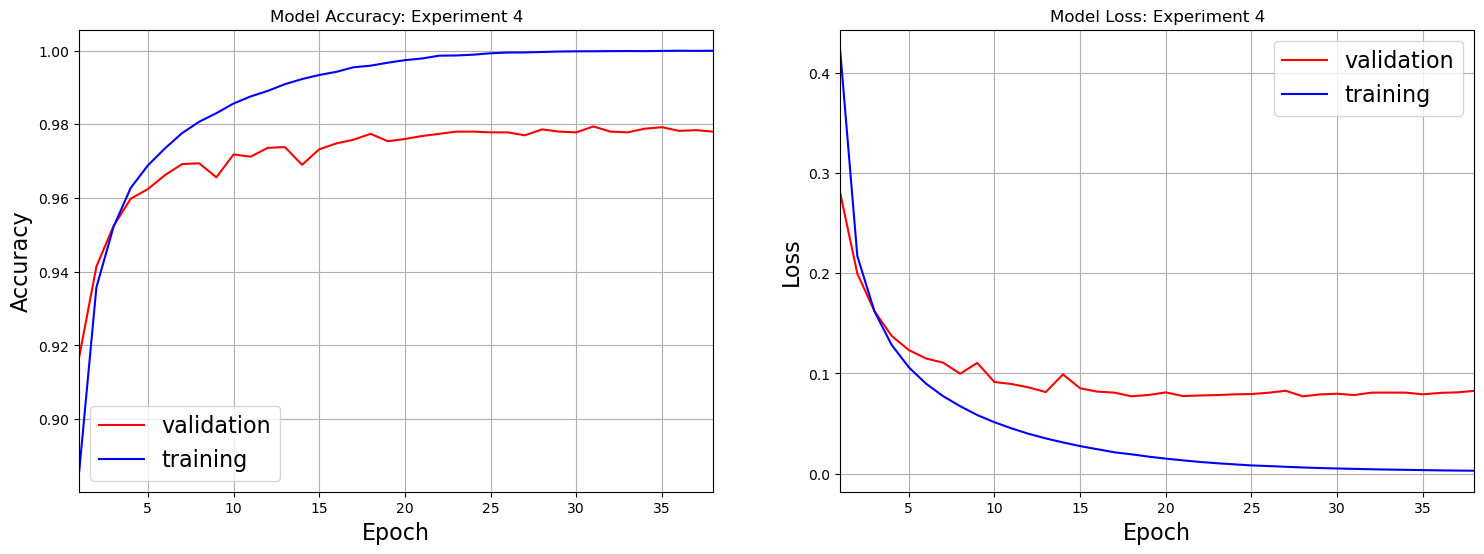

CPU times: total: 10min 58s
Wall time: 55.6 s


In [ ]:
%%time
model_ex4, history_ex4 = training_wrapper(
    ex_num=4,
    model=model_ex4,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [25]:
y_pred_ex4 = evaluation_wrapper(
    ex_num=4,
    model=model_ex4,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 4...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9998
Test Accuracy: 0.98

Confusion Matrix:
[[ 970    0    1    2    2    2    0    1    1    1]
 [   0 1125    2    1    0    1    3    1    2    0]
 [   3    1 1013    4    1    0    2    3    5    0]
 [   0    0    3  995    0    1    0    3    2    6]
 [   1    1    3    1  958    0    2    3    1   12]
 [   2    0    0   10    1  871    3    1    2    2]
 [   6    3    2    1    3    5  937    0    1    0]
 [   1    4    6    1    0    0    0 1006    4    6]
 [   3    0    3    8    3    3    2    3  947    2]
 [   2    3    0    8   10    4    0    3    1  978]]

***************************************************************************************
***************

## Experiment 5
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [26]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex5 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex5 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex5 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex5.compile(optimizer=optimizer_ex5, loss=loss_fn_ex5, metrics=['accuracy'])

model_ex5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 5...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 0.4417 - accuracy: 0.8749 - val_loss: 0.2696 - val_accuracy: 0.9170
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1716 - accuracy: 0.9486 - val_loss: 0.1637 - val_accuracy: 0.9504
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1185 - accuracy: 0.9651 - val_loss: 0.1252 - val_accuracy: 0.9624
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0897 - accuracy: 0.9731 - val_loss: 0.1201 - val_accuracy: 0.9648
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0703 - accuracy: 0.9788 - val_loss: 0.1029 - val_accuracy: 0.9666
Epo

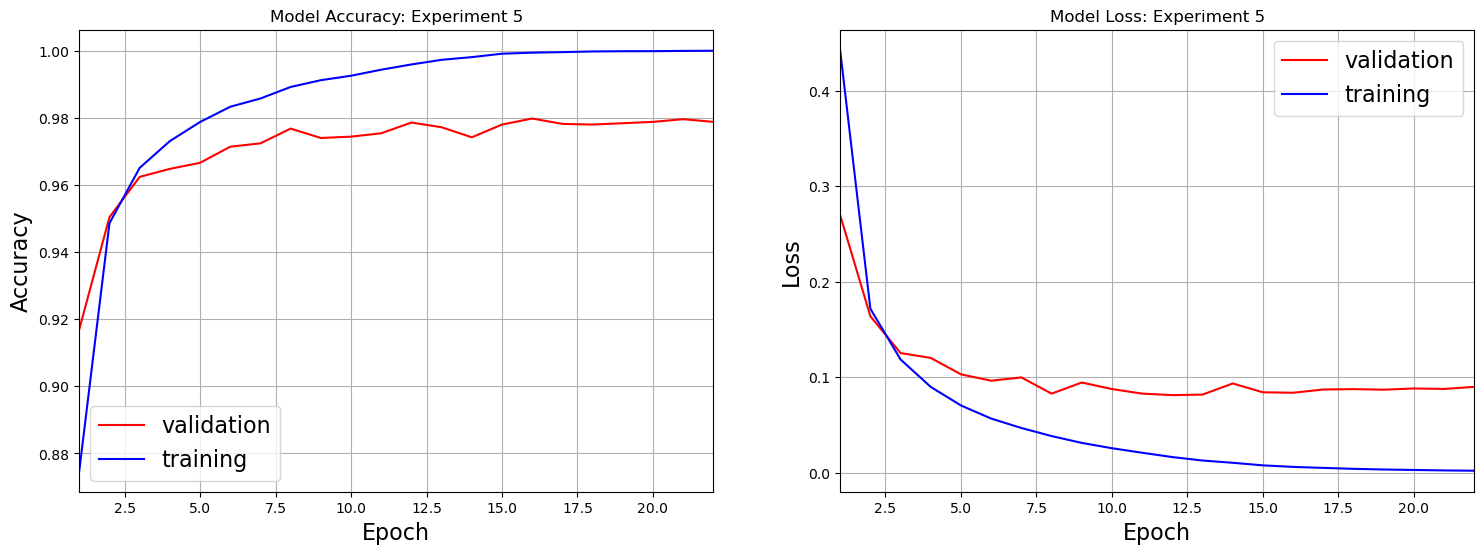

CPU times: total: 7min 21s
Wall time: 38.4 s


In [ ]:
%%time
model_ex5, history_ex5 = training_wrapper(
    ex_num=5,
    model=model_ex5,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [28]:
y_pred_ex5 = evaluation_wrapper(
    ex_num=5,
    model=model_ex5,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 5...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9977
Test Accuracy: 0.9786

Confusion Matrix:
[[ 972    1    1    1    0    0    2    1    2    0]
 [   0 1126    2    1    0    1    2    0    3    0]
 [   5    2 1003    7    1    0    3    5    6    0]
 [   1    0    2  996    0    3    0    1    4    3]
 [   1    0    2    0  965    0    4    1    2    7]
 [   3    0    0   13    0  864    6    1    3    2]
 [   4    3    1    1    3    4  940    0    2    0]
 [   2    4    5    5    0    0    0 1004    2    6]
 [   5    0    2    8    2    6    4    3  939    5]
 [   5    2    0    7    9    2    0    1    6  977]]

***************************************************************************************
*************

## Experiment 6
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers)
    - Hidden layer 1: rate=0.1
    - Hidden layer 2: rate=0.1
- Max 50 epochs with early exit

### Construct and Compile Model

In [29]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex6 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex6 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex6 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex6.compile(optimizer=optimizer_ex6, loss=loss_fn_ex6, metrics=['accuracy'])

model_ex6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

### Train Model

Starting Experiment 6...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.4742 - accuracy: 0.8633 - val_loss: 0.2572 - val_accuracy: 0.9222
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1944 - accuracy: 0.9418 - val_loss: 0.1522 - val_accuracy: 0.9558
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1370 - accuracy: 0.9592 - val_loss: 0.1222 - val_accuracy: 0.9616
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1083 - accuracy: 0.9675 - val_loss: 0.1069 - val_accuracy: 0.9664
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0886 - accuracy: 0.9721 - val_loss: 0.0899 - val_accuracy: 0.9718
Epo

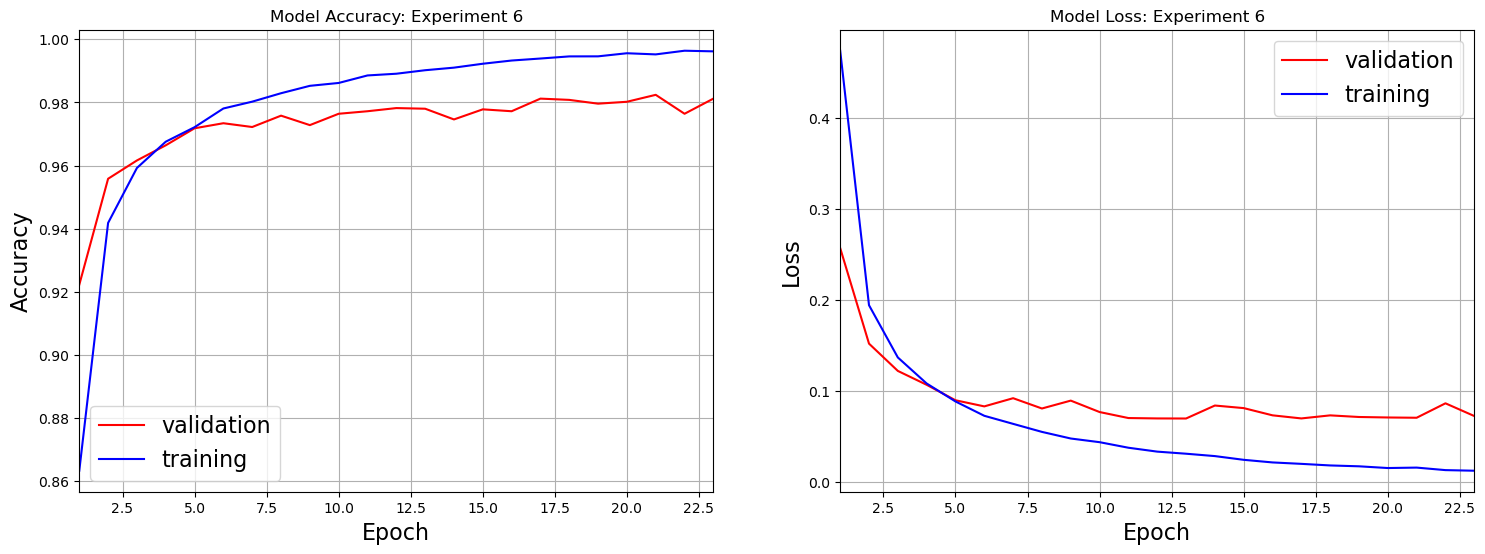

CPU times: total: 9min 23s
Wall time: 48.5 s


In [ ]:
%%time
model_ex6, history_ex6 = training_wrapper(
    ex_num=6,
    model=model_ex6,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [31]:
y_pred_ex6 = evaluation_wrapper(
    ex_num=6,
    model=model_ex6,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 6...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9972
Test Accuracy: 0.9814

Confusion Matrix:
[[ 970    0    1    2    1    0    1    1    3    1]
 [   0 1127    2    1    0    1    2    0    2    0]
 [   1    1 1008    5    3    0    2    5    7    0]
 [   0    0    1 1002    0    0    0    2    3    2]
 [   2    0    2    0  965    0    5    2    0    6]
 [   2    0    0   13    1  867    2    0    5    2]
 [   4    2    1    1    5    3  941    0    1    0]
 [   2    7    6    4    1    0    0  999    4    5]
 [   2    0    1    5    1    2    1    4  955    3]
 [   2    2    0    6    9    2    2    3    3  980]]

***************************************************************************************
*************

## Experiment 7
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers)
    - Hidden layer 1: rate=0.5
    - Hidden layer 2: rate=0.1
- Max 50 epochs with early exit

### Construct and Compile Model

In [32]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex7 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex7 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex7 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex7.compile(optimizer=optimizer_ex7, loss=loss_fn_ex7, metrics=['accuracy'])

model_ex7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

### Train Model

Starting Experiment 7...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.5591 - accuracy: 0.8287 - val_loss: 0.2395 - val_accuracy: 0.9250
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 0.2498 - accuracy: 0.9250 - val_loss: 0.1707 - val_accuracy: 0.9444
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1936 - accuracy: 0.9416 - val_loss: 0.1318 - val_accuracy: 0.9592
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1641 - accuracy: 0.9498 - val_loss: 0.1225 - val_accuracy: 0.9624
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1415 - accuracy: 0.9579 - val_loss: 0.1077 - val_accuracy: 0.9646
Epo

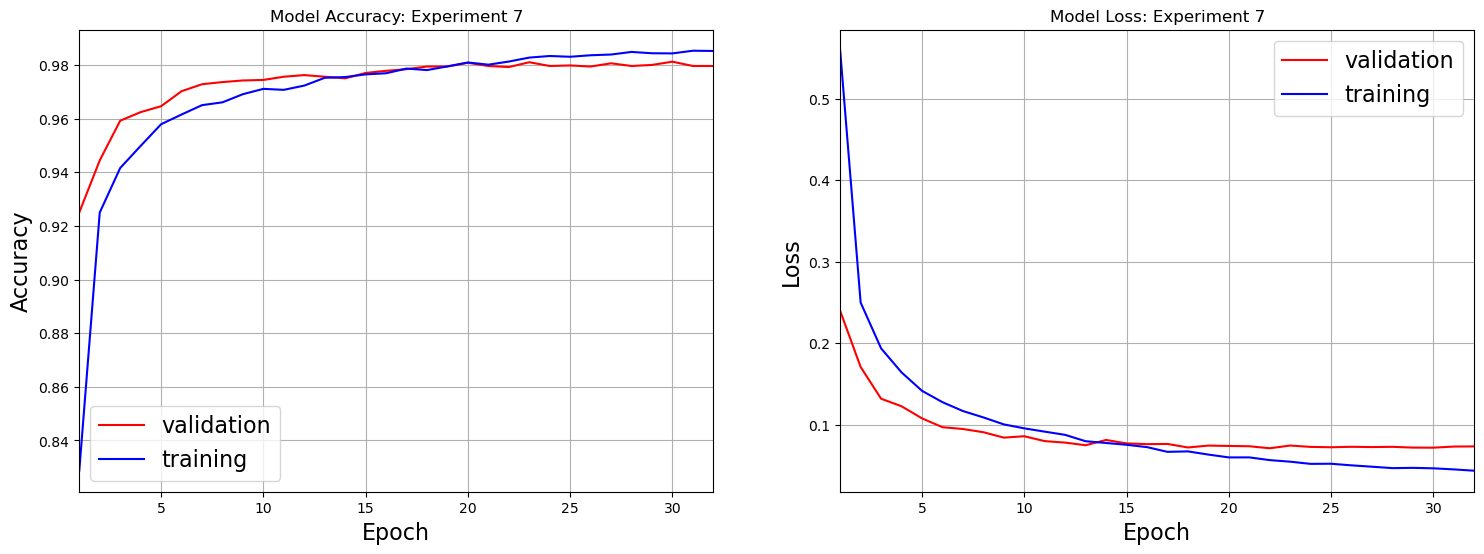

CPU times: total: 13min 3s
Wall time: 1min 7s


In [ ]:
%%time
model_ex7, history_ex7 = training_wrapper(
    ex_num=7,
    model=model_ex7,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [34]:
y_pred_ex7 = evaluation_wrapper(
    ex_num=7,
    model=model_ex7,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 7...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9954
Test Accuracy: 0.9809

Confusion Matrix:
[[ 972    0    1    1    0    1    1    1    2    1]
 [   0 1129    1    1    0    1    3    0    0    0]
 [   1    1 1016    3    3    0    1    5    2    0]
 [   0    0    5  991    0    4    0    4    2    4]
 [   0    0    1    0  962    0    5    3    0   11]
 [   2    0    0    6    1  869    5    1    5    3]
 [   6    3    0    1    4    4  937    0    3    0]
 [   1    5    9    2    0    0    0 1004    0    7]
 [   4    0    1    7    0    2    5    6  946    3]
 [   4    2    0    4    7    1    0    7    1  983]]

***************************************************************************************
*************

## Experiment 8
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.5
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers)
    - Hidden layer 1: rate=0.5
    - Hidden layer 2: rate=0.1
- Max 50 epochs with early exit

### Construct and Compile Model

In [35]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex8 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex8 = tf.keras.optimizers.SGD(learning_rate=0.5)
loss_fn_ex8 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex8.compile(optimizer=optimizer_ex8, loss=loss_fn_ex8, metrics=['accuracy'])

model_ex8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

### Train Model

Starting Experiment 8...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.4108 - accuracy: 0.8717 - val_loss: 0.1713 - val_accuracy: 0.9472
Epoch 2/50
860/860 [==============================] - 2s 3ms/step - loss: 0.2092 - accuracy: 0.9358 - val_loss: 0.1396 - val_accuracy: 0.9550
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1691 - accuracy: 0.9490 - val_loss: 0.1292 - val_accuracy: 0.9622
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1500 - accuracy: 0.9546 - val_loss: 0.1087 - val_accuracy: 0.9662
Epoch 5/50
860/860 [==============================] - 2s 3ms/step - loss: 0.1374 - accuracy: 0.9578 - val_loss: 0.1087 - val_accuracy: 0.9682
Epo

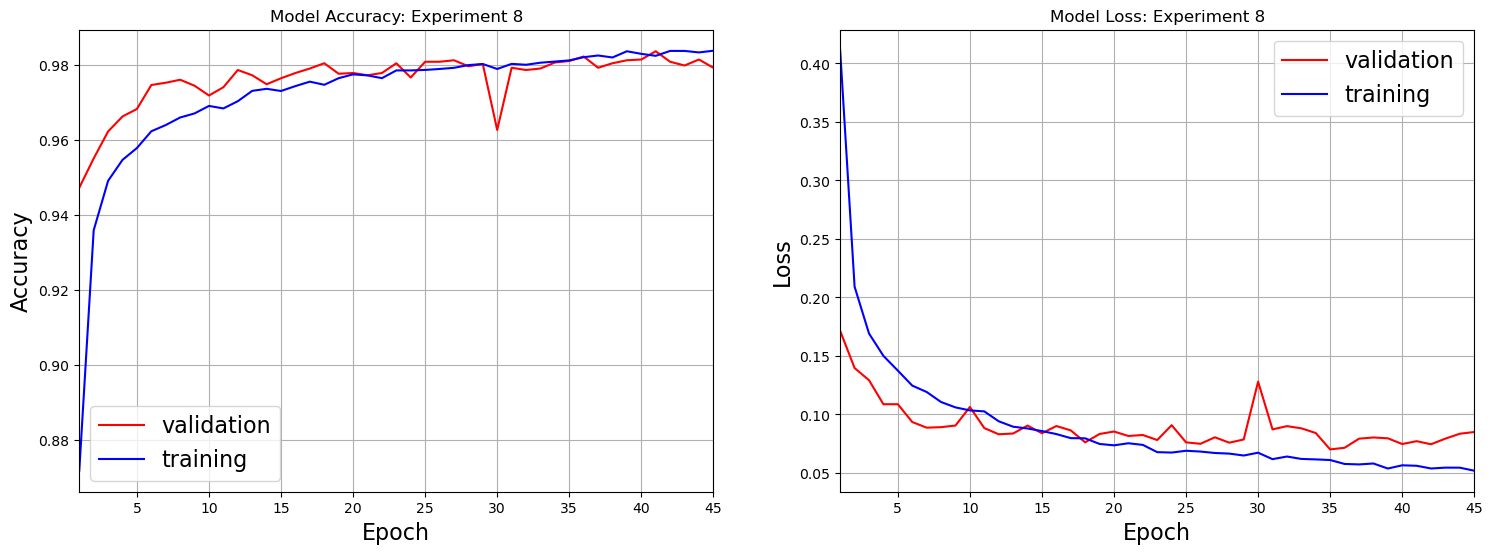

CPU times: total: 18min 23s
Wall time: 1min 35s


In [ ]:
%%time
model_ex8, history_ex8 = training_wrapper(
    ex_num=8,
    model=model_ex8,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [37]:
y_pred_ex8 = evaluation_wrapper(
    ex_num=8,
    model=model_ex8,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 8...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9962
Test Accuracy: 0.9833

Confusion Matrix:
[[ 974    1    0    0    0    0    2    1    1    1]
 [   0 1133    0    0    0    1    1    0    0    0]
 [   1    0 1019    0    0    0    2    8    2    0]
 [   0    0    5  992    0    4    0    4    1    4]
 [   0    1    1    1  955    0    5    3    1   15]
 [   3    1    0    7    1  873    2    1    3    1]
 [   5    2    0    0    2    3  944    0    2    0]
 [   2    4    6    0    0    0    0 1010    3    3]
 [   8    0    2    2    3    3    0    3  951    2]
 [   2    5    2    5    7    0    1    5    0  982]]

***************************************************************************************
*************

## Experiment 9
Create a deep feed forward network with the following characteristics:
- 10 hidden layers each with 100 neurons
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [38]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex9 = tf.keras.models.Sequential()
model_ex9.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

for i in range(10):
    model_ex9.add(
        tf.keras.layers.Dense(
            100, activation='relu', kernel_initializer='random_normal', name=f'hidden{i}'
        )
    )

model_ex9.add(
    tf.keras.layers.Dense(
        10, activation='softmax', kernel_initializer='random_normal', name='output'
    )
)

optimizer_ex9 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex9 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex9.compile(optimizer=optimizer_ex9, loss=loss_fn_ex9, metrics=['accuracy'])

model_ex9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden0 (Dense)             (None, 100)               78500     
                                                                 
 hidden1 (Dense)             (None, 100)               10100     
                                                                 
 hidden2 (Dense)             (None, 100)               10100     
                                                                 
 hidden3 (Dense)             (None, 100)               10100     
                                                                 
 hidden4 (Dense)             (None, 100)               10100     
                                                                 
 hidden5 (Dense)             (None, 100)               1

### Train Model

Starting Experiment 9...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3017 - accuracy: 0.1116 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 2/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3016 - accuracy: 0.1121 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 3/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3016 - accuracy: 0.1122 - val_loss: 2.3015 - val_accuracy: 0.1124
Epoch 4/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3016 - accuracy: 0.1124 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 5/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3016 - accuracy: 0.1124 - val_loss: 2.3014 - val_accuracy: 0.1124
Epo

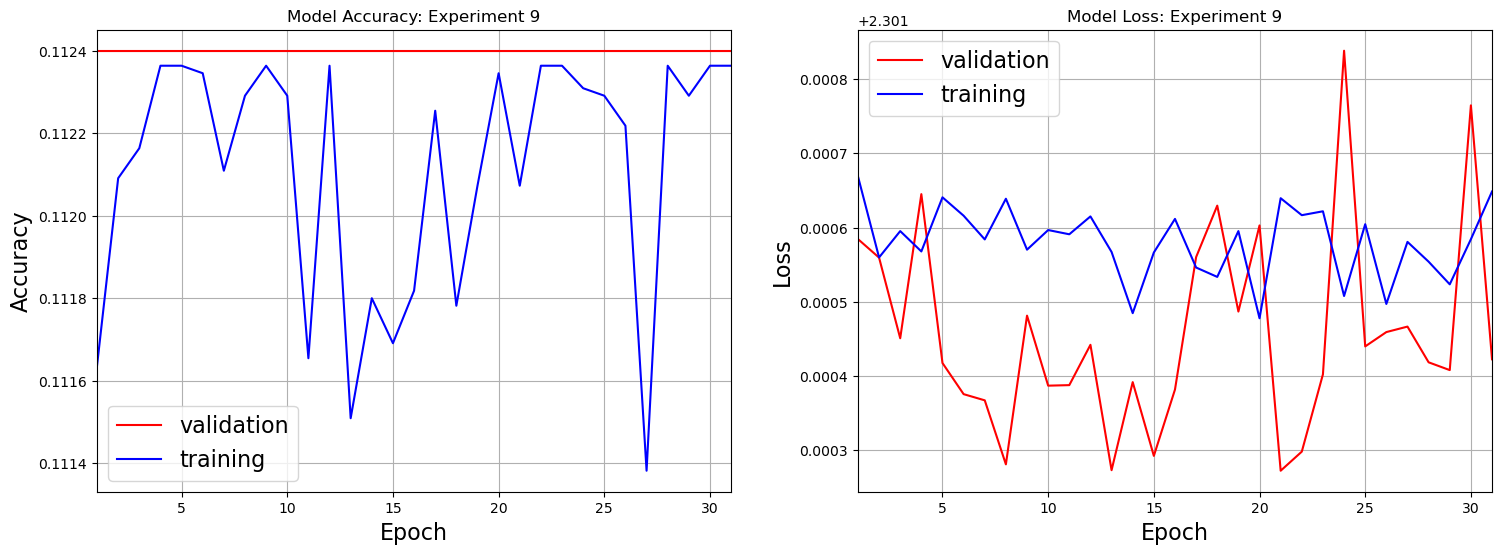

CPU times: total: 16min 59s
Wall time: 1min 28s


In [ ]:
%%time
model_ex9, history_ex9 = training_wrapper(
    ex_num=9,
    model=model_ex9,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [40]:
y_pred_ex9 = evaluation_wrapper(
    ex_num=9,
    model=model_ex9,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 9...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.1124
Test Accuracy: 0.1135

Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

***************************************************************************************
*************

## Experiment 10
Create a deep feed forward network with the following characteristics:
- 20 hidden layers each with 100 neurons
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [41]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex10 = tf.keras.models.Sequential()
model_ex10.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

for i in range(20):
    model_ex10.add(
        tf.keras.layers.Dense(
            100, activation='relu', kernel_initializer='random_normal', name=f'hidden{i}'
        )
    )

model_ex10.add(
    tf.keras.layers.Dense(
        10, activation='softmax', kernel_initializer='random_normal', name='output'
    )
)

optimizer_ex10 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex10 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex10.compile(optimizer=optimizer_ex10, loss=loss_fn_ex10, metrics=['accuracy'])

model_ex10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden0 (Dense)             (None, 100)               78500     
                                                                 
 hidden1 (Dense)             (None, 100)               10100     
                                                                 
 hidden2 (Dense)             (None, 100)               10100     
                                                                 
 hidden3 (Dense)             (None, 100)               10100     
                                                                 
 hidden4 (Dense)             (None, 100)               10100     
                                                                 
 hidden5 (Dense)             (None, 100)               1

### Train Model

Starting Experiment 10...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 6s 6ms/step - loss: 2.3017 - accuracy: 0.1116 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 2/50
860/860 [==============================] - 4s 4ms/step - loss: 2.3016 - accuracy: 0.1122 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 3/50
860/860 [==============================] - 4s 4ms/step - loss: 2.3016 - accuracy: 0.1122 - val_loss: 2.3015 - val_accuracy: 0.1124
Epoch 4/50
860/860 [==============================] - 4s 5ms/step - loss: 2.3016 - accuracy: 0.1124 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 5/50
860/860 [==============================] - 4s 5ms/step - loss: 2.3016 - accuracy: 0.1124 - val_loss: 2.3014 - val_accuracy: 0.1124
Ep

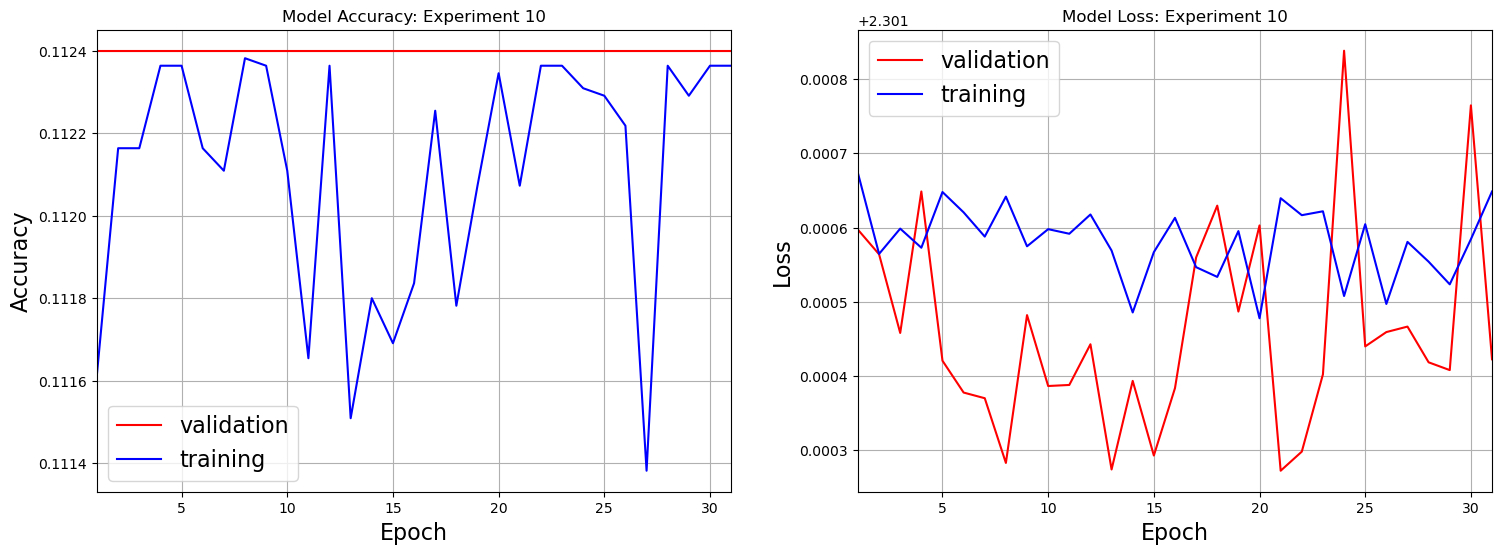

CPU times: total: 22min 41s
Wall time: 1min 56s


In [ ]:
%%time
model_ex10, history_ex10 = training_wrapper(
    ex_num=10,
    model=model_ex10,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### Evaluating Trained Model

In [43]:
y_pred_ex10 = evaluation_wrapper(
    ex_num=10,
    model=model_ex10,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 10...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.1124
Test Accuracy: 0.1135

Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

***************************************************************************************
************

## Experiment 11
Create a deep feed forward network with the following characteristics:
- 4 hidden layers
    - Hidden layer 1: neurons=100
    - Hidden layer 2: neurons=300
    - Hidden layer 3: neurons=300
    - Hidden layer 4: neurons=100
- SGD Learning Rate: Determine an optimal value.
- kernel_initializer (all layers): Determine an optimal value.
- activation (hidden layers): Determine an optimal value.
- Dropout (hidden layers): Determine an optimal value.
- Max 50 epochs with early exit

### (01) Construct and Compile Model

In [79]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1101 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden3'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden4'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1101 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1101 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1101.compile(optimizer=optimizer_ex1101, loss=loss_fn_ex1101, metrics=['accuracy'])

model_ex1101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 hidden4 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 230,210
Trainable params: 230,210
Non-trai

### (01) Train Model

Starting Experiment 1101...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.6121 - accuracy: 0.8073 - val_loss: 0.2406 - val_accuracy: 0.9242
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1656 - accuracy: 0.9504 - val_loss: 0.2696 - val_accuracy: 0.9168
Epoch 3/50
860/860 [==============================] - 2s 3ms/step - loss: 0.1156 - accuracy: 0.9654 - val_loss: 0.1175 - val_accuracy: 0.9644
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0874 - accuracy: 0.9741 - val_loss: 0.1094 - val_accuracy: 0.9666
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.0952 - val_accuracy: 0.9686


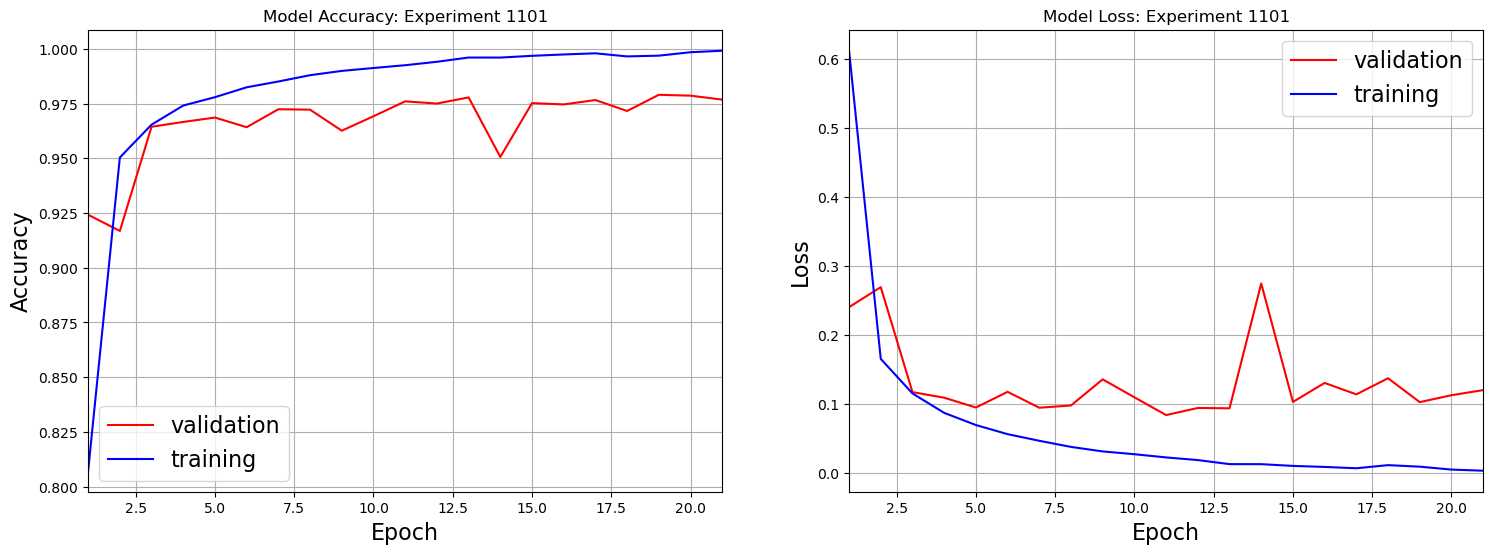

CPU times: total: 8min 5s
Wall time: 43.2 s


In [80]:
%%time
model_ex1101, history_ex1101 = training_wrapper(
    ex_num=1101,
    model=model_ex1101,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (01) Evaluating Trained Model

In [81]:
y_pred_ex1101 = evaluation_wrapper(
    ex_num=1101,
    model=model_ex1101,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1101...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9945
Test Accuracy: 0.9776

Confusion Matrix:
[[ 972    1    0    1    0    0    2    1    2    1]
 [   0 1127    1    1    0    1    3    0    2    0]
 [   3    1 1013    6    1    0    2    4    2    0]
 [   0    0    4  978    0   19    0    4    3    2]
 [   2    0    3    0  947    4    4    0    2   20]
 [   2    0    0    2    0  881    4    0    2    1]
 [   2    1    0    0    9    6  939    0    1    0]
 [   0    5    8    4    0    1    0 1006    1    3]
 [   2    0    3   11    3    9    2    3  937    4]
 [   2    2    0    7    6    7    1    3    5  976]]

***************************************************************************************
**********

### (02) Construct and Compile Model

In [83]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1102 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1102 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1102 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1102.compile(optimizer=optimizer_ex1102, loss=loss_fn_ex1102, metrics=['accuracy'])

model_ex1102.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 hidden4 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 230,210
Trainable params: 230,210
Non-trai

### (02) Train Model

Starting Experiment 1102...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.3565 - accuracy: 0.8883 - val_loss: 0.1965 - val_accuracy: 0.9420
Epoch 2/50
860/860 [==============================] - 2s 3ms/step - loss: 0.1333 - accuracy: 0.9592 - val_loss: 0.2708 - val_accuracy: 0.9192
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0921 - accuracy: 0.9717 - val_loss: 0.1215 - val_accuracy: 0.9644
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9765 - val_loss: 0.0993 - val_accuracy: 0.9704
Epoch 5/50
860/860 [==============================] - 1s 2ms/step - loss: 0.0562 - accuracy: 0.9820 - val_loss: 0.1010 - val_accuracy: 0.9688


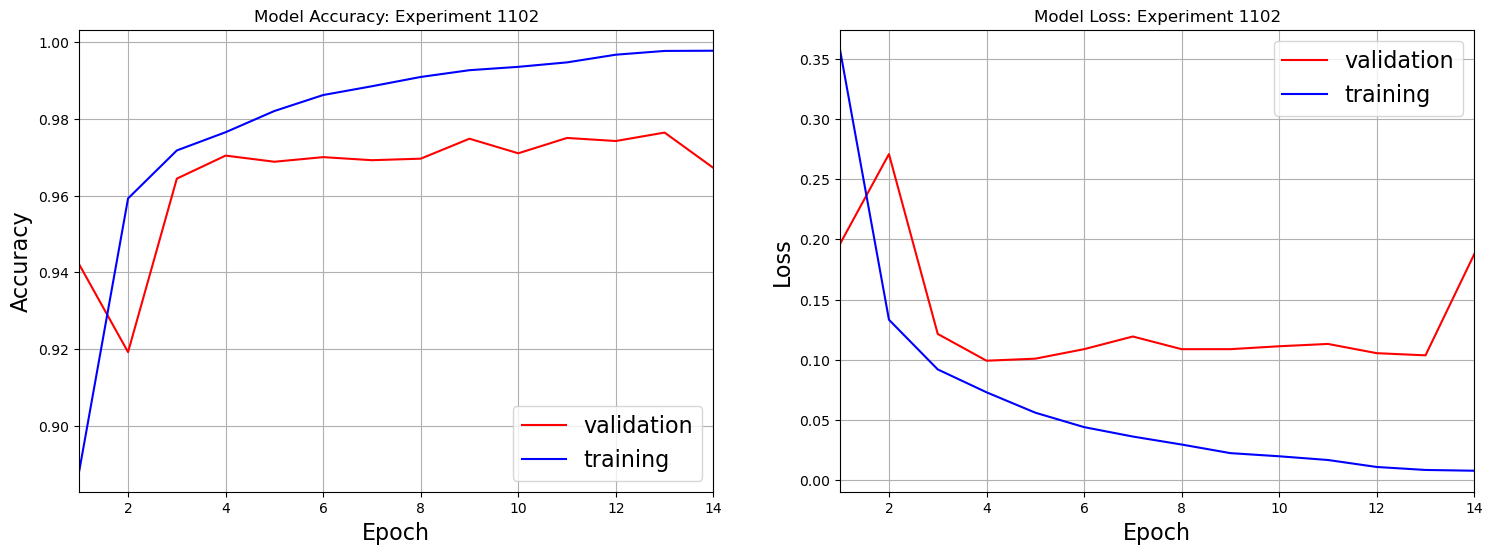

CPU times: total: 5min 17s
Wall time: 28.7 s


In [84]:
%%time
model_ex1102, history_ex1102 = training_wrapper(
    ex_num=1102,
    model=model_ex1102,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (02) Evaluating Trained Model

In [85]:
y_pred_ex1102 = evaluation_wrapper(
    ex_num=1102,
    model=model_ex1102,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1102...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.983
Test Accuracy: 0.9719

Confusion Matrix:
[[ 970    0    0    1    0    2    2    1    3    1]
 [   0 1126    3    2    0    1    1    0    2    0]
 [   4    1 1006    2    1    1    2   11    4    0]
 [   0    0    4  984    0    7    0    9    6    0]
 [   0    3    5    0  957    1    7    5    0    4]
 [   4    1    0   10    1  867    6    1    2    0]
 [   9    3    0    0    2   11  933    0    0    0]
 [   1    9    2    3    1    0    0 1008    0    4]
 [   5    1    7    8    3    8    7    6  929    0]
 [   3    7    1   11   18   11    1   15    3  939]]

***************************************************************************************
***********

### (03) Construct and Compile Model

In [97]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1103 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1103 = tf.keras.optimizers.SGD()
loss_fn_ex1103 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1103.compile(optimizer=optimizer_ex1103, loss=loss_fn_ex1103, metrics=['accuracy'])

model_ex1103.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 hidden4 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 230,210
Trainable params: 230,210
Non-trai

### (03) Train Model

In [98]:
# The following learning rate scheduler should get the learning rate down to 0.1 after ~15 epochs
lr_scheduler_ex1103 = tf.keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.5, decay_steps=1, decay_rate=0.90
    )
)

In [100]:
# Let's relax the early stopping criteria a bit to allow for the learning rate to decay
early_stopping_ex1103 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    min_delta=0,
    patience=15,
    restore_best_weights=True
)

Starting Experiment 1103...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.5366 - accuracy: 0.8279 - val_loss: 0.2070 - val_accuracy: 0.9358 - lr: 0.5000
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1501 - accuracy: 0.9564 - val_loss: 0.1512 - val_accuracy: 0.9552 - lr: 0.4500
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1018 - accuracy: 0.9698 - val_loss: 0.2161 - val_accuracy: 0.9420 - lr: 0.4050
Epoch 4/50
860/860 [==============================] - 2s 3ms/step - loss: 0.0765 - accuracy: 0.9765 - val_loss: 0.1103 - val_accuracy: 0.9686 - lr: 0.3645
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 0.0567 - accurac

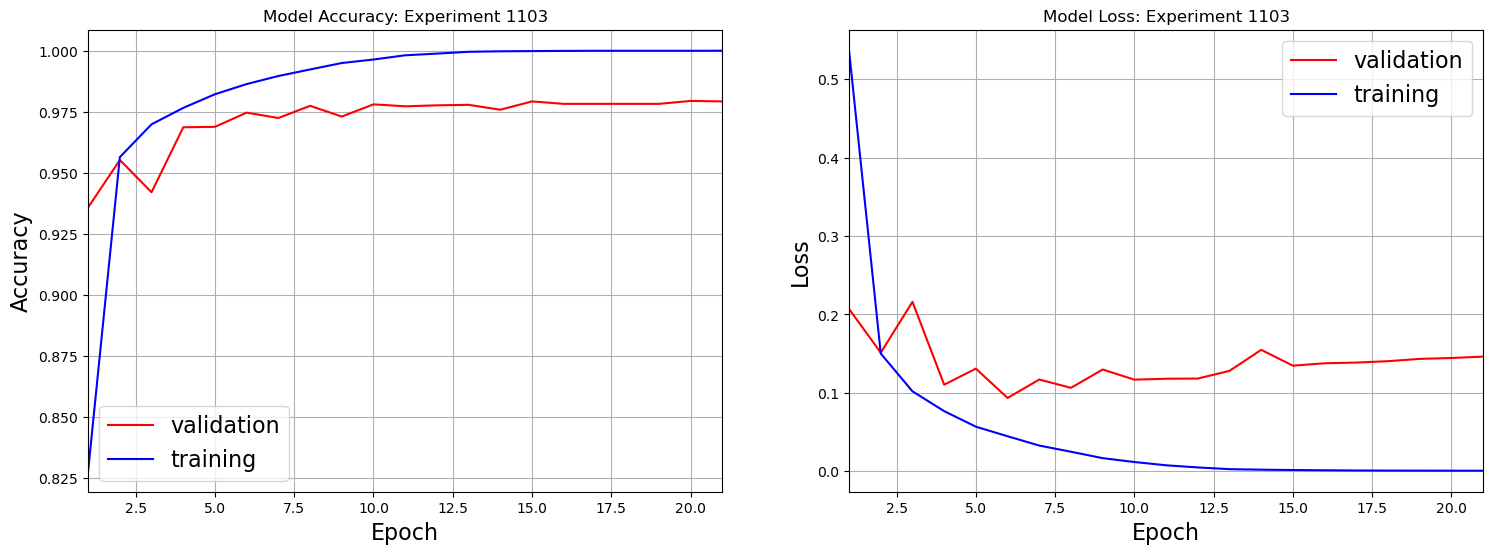

CPU times: total: 8min 9s
Wall time: 43.6 s


In [101]:
%%time
model_ex1103, history_ex1103 = training_wrapper(
    ex_num=1103,
    model=model_ex1103,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping_ex1103, lr_scheduler_ex1103]
)

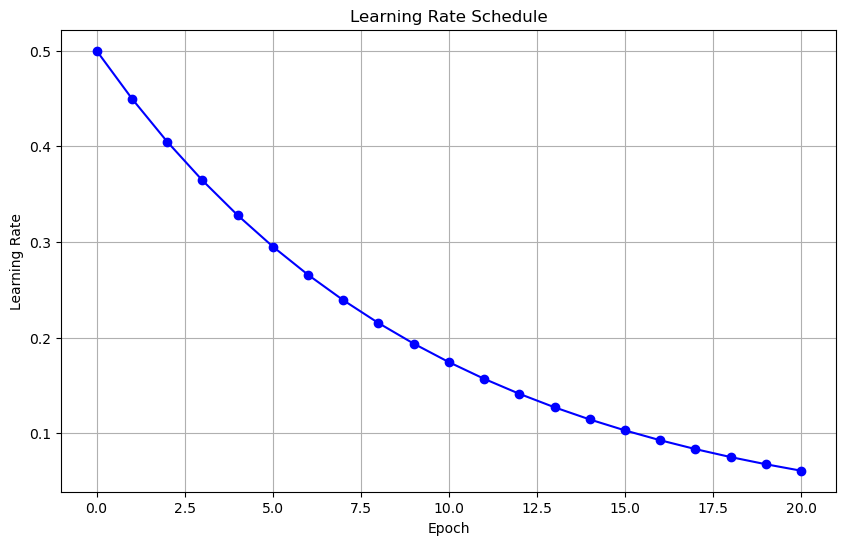

In [102]:
# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(history_ex1103.epoch, history_ex1103.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()


### (03) Evaluating Trained Model

In [103]:
y_pred_ex1103 = evaluation_wrapper(
    ex_num=1103,
    model=model_ex1103,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1103...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9915
Test Accuracy: 0.9763

Confusion Matrix:
[[ 963    0    0    1    0    1    2    4    3    6]
 [   0 1125    0    0    0    1    2    1    6    0]
 [   2    1 1005    9    3    1    0    3    7    1]
 [   0    0    3  993    0    3    0    5    2    4]
 [   0    0    4    0  960    0    4    2    1   11]
 [   1    0    1   17    1  859    1    2    5    5]
 [   4    3    0    1    8    4  932    0    6    0]
 [   0    2   12    3    0    0    0 1002    3    6]
 [   4    0    2    3    6    2    1    3  951    2]
 [   1    2    1    3   10    4    1    7    7  973]]

***************************************************************************************
**********

### (04) Construct and Compile Model

In [111]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1104 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1104 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1104 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1104.compile(optimizer=optimizer_ex1104, loss=loss_fn_ex1104, metrics=['accuracy'])

model_ex1104.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0

### (04) Train Model

Starting Experiment 1104...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 4s 4ms/step - loss: 0.4353 - accuracy: 0.8641 - val_loss: 0.1810 - val_accuracy: 0.9430
Epoch 2/50
860/860 [==============================] - 3s 3ms/step - loss: 0.1868 - accuracy: 0.9443 - val_loss: 0.1468 - val_accuracy: 0.9520
Epoch 3/50
860/860 [==============================] - 3s 3ms/step - loss: 0.1431 - accuracy: 0.9561 - val_loss: 0.1583 - val_accuracy: 0.9520
Epoch 4/50
860/860 [==============================] - 3s 3ms/step - loss: 0.1210 - accuracy: 0.9623 - val_loss: 0.1228 - val_accuracy: 0.9622
Epoch 5/50
860/860 [==============================] - 3s 4ms/step - loss: 0.1080 - accuracy: 0.9672 - val_loss: 0.0985 - val_accuracy: 0.9700


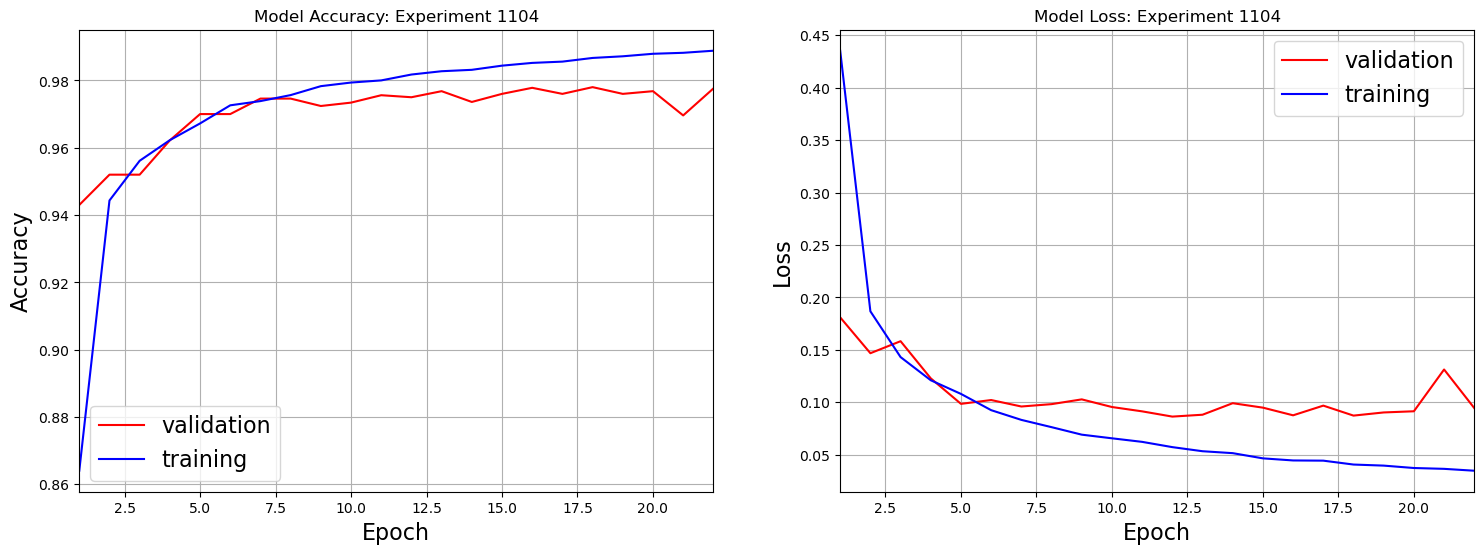

CPU times: total: 10min 23s
Wall time: 54.4 s


In [112]:
%%time
model_ex1104, history_ex1104 = training_wrapper(
    ex_num=1104,
    model=model_ex1104,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (04) Evaluating Trained Model

In [113]:
y_pred_ex1104 = evaluation_wrapper(
    ex_num=1104,
    model=model_ex1104,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1104...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9931
Test Accuracy: 0.9777

Confusion Matrix:
[[ 971    0    1    0    0    1    4    1    1    1]
 [   0 1123    2    3    0    0    3    1    3    0]
 [   3    2 1007    4    3    0    2    8    3    0]
 [   1    0    4  990    0    2    0    6    3    4]
 [   1    0    3    0  964    0    4    2    0    8]
 [   5    0    0   17    2  855    3    1    5    4]
 [   4    3    0    1    5    1  939    0    5    0]
 [   0    3    8    3    0    0    0 1009    1    4]
 [   4    2    1   11    3    3    3    4  940    3]
 [   3    5    0    6   10    0    0    4    2  979]]

***************************************************************************************
**********

### (05) Construct and Compile Model

In [115]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1105 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1105 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1105 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1105.compile(optimizer=optimizer_ex1105, loss=loss_fn_ex1105, metrics=['accuracy'])

model_ex1105.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0

### (05) Train Model

Starting Experiment 1105...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.6651 - accuracy: 0.7839 - val_loss: 0.2646 - val_accuracy: 0.9180
Epoch 2/50
860/860 [==============================] - 2s 3ms/step - loss: 0.2873 - accuracy: 0.9176 - val_loss: 0.1760 - val_accuracy: 0.9480
Epoch 3/50
860/860 [==============================] - 2s 3ms/step - loss: 0.2247 - accuracy: 0.9361 - val_loss: 0.1748 - val_accuracy: 0.9504
Epoch 4/50
860/860 [==============================] - 2s 3ms/step - loss: 0.1897 - accuracy: 0.9460 - val_loss: 0.1425 - val_accuracy: 0.9604
Epoch 5/50
860/860 [==============================] - 2s 3ms/step - loss: 0.1698 - accuracy: 0.9514 - val_loss: 0.1135 - val_accuracy: 0.9670


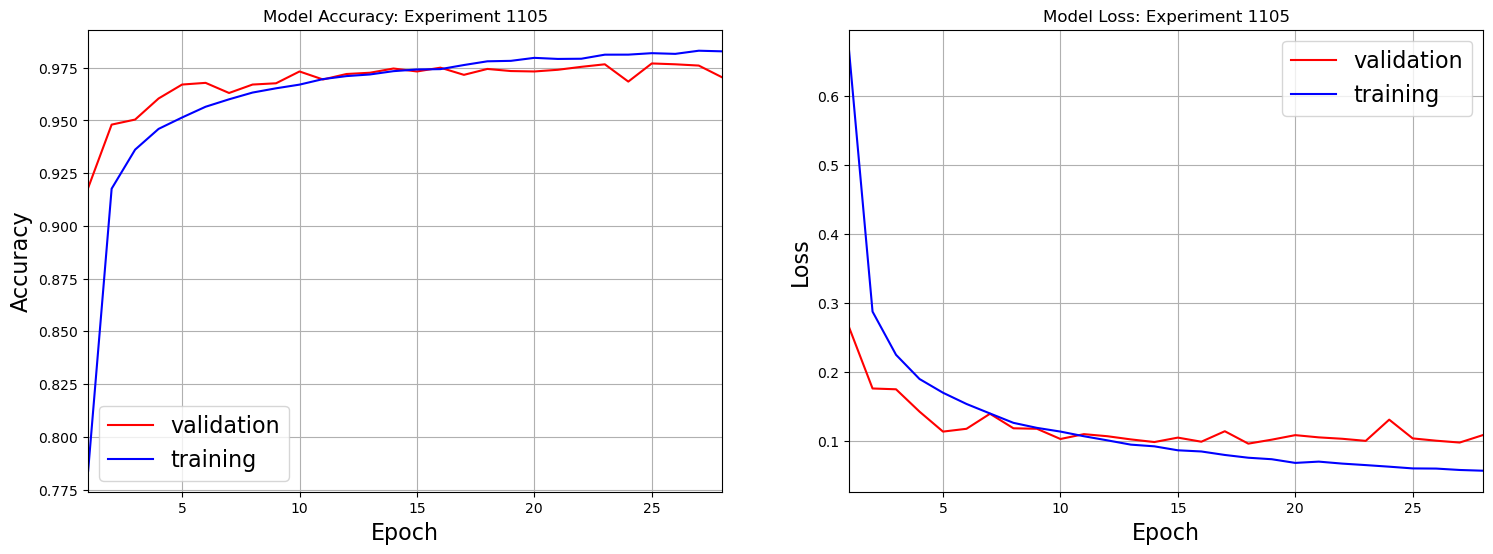

CPU times: total: 13min 4s
Wall time: 1min 7s


In [116]:
%%time
model_ex1105, history_ex1105 = training_wrapper(
    ex_num=1105,
    model=model_ex1105,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (05) Evaluating Trained Model

In [117]:
y_pred_ex1105 = evaluation_wrapper(
    ex_num=1105,
    model=model_ex1105,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1105...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9908
Test Accuracy: 0.9745

Confusion Matrix:
[[ 968    1    0    0    0    2    2    3    2    2]
 [   0 1117    3    1    0    1    1    1   11    0]
 [   5    2 1001    4    1    0    4    8    7    0]
 [   0    0    3  984    0    6    0    7    5    5]
 [   2    0    0    0  946    0    5    2    3   24]
 [   2    0    0    5    1  872    2    3    3    4]
 [   5    2    0    0    8    6  930    1    6    0]
 [   1    4   10    3    0    1    0  996    6    7]
 [   5    0    2    2    4    1    3    4  948    5]
 [   3    3    0    4    5    2    0    6    3  983]]

***************************************************************************************
**********

### (06) Construct and Compile Model

In [155]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1106 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1106 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1106 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1106.compile(optimizer=optimizer_ex1106, loss=loss_fn_ex1106, metrics=['accuracy'])

model_ex1106.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0

### (06) Train Model

Starting Experiment 1106...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 4s 4ms/step - loss: 0.4336 - accuracy: 0.8623 - val_loss: 0.1821 - val_accuracy: 0.9408
Epoch 2/50
860/860 [==============================] - 3s 4ms/step - loss: 0.1727 - accuracy: 0.9481 - val_loss: 0.1348 - val_accuracy: 0.9568
Epoch 3/50
860/860 [==============================] - 3s 4ms/step - loss: 0.1254 - accuracy: 0.9621 - val_loss: 0.1134 - val_accuracy: 0.9672
Epoch 4/50
860/860 [==============================] - 3s 3ms/step - loss: 0.1027 - accuracy: 0.9686 - val_loss: 0.1030 - val_accuracy: 0.9694
Epoch 5/50
860/860 [==============================] - 3s 4ms/step - loss: 0.0880 - accuracy: 0.9733 - val_loss: 0.1031 - val_accuracy: 0.9692


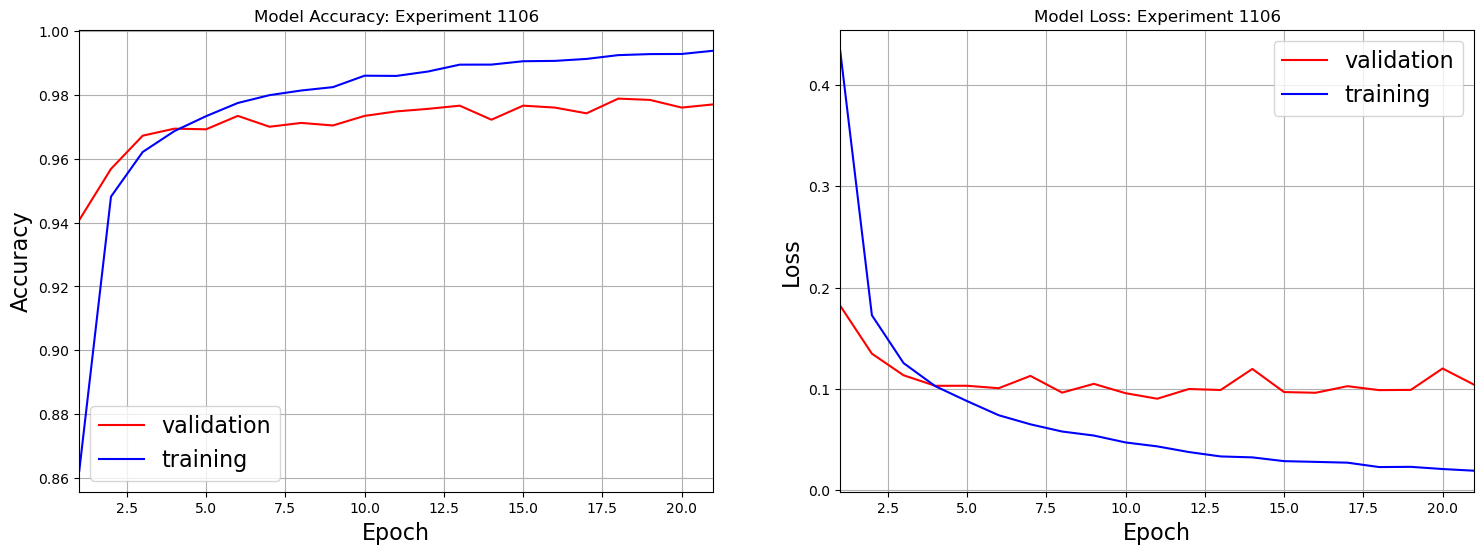

CPU times: total: 12min 6s
Wall time: 1min 4s


In [156]:
%%time
model_ex1106, history_ex1106 = training_wrapper(
    ex_num=1106,
    model=model_ex1106,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (06) Evaluating Trained Model

In [157]:
y_pred_ex1106 = evaluation_wrapper(
    ex_num=1106,
    model=model_ex1106,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1106...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9946
Test Accuracy: 0.9798

Confusion Matrix:
[[ 968    0    0    2    0    0    5    1    3    1]
 [   0 1128    2    0    0    1    2    1    1    0]
 [   4    0 1017    1    2    0    2    2    4    0]
 [   0    0    6  991    0    3    0    4    4    2]
 [   1    0    5    0  963    1    3    1    1    7]
 [   3    0    0   15    1  848   11    1   10    3]
 [   2    2    0    1    4    1  945    0    3    0]
 [   1    5    9    2    2    0    0 1000    4    5]
 [   1    0    6    4    1    1    2    2  956    1]
 [   3    2    0    6    7    1    0    5    3  982]]

***************************************************************************************
**********

### (07) Construct and Compile Model

In [143]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1107 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1107 = tf.keras.optimizers.experimental.AdamW() # just use the defaults to try it out
loss_fn_ex1107 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1107.compile(optimizer=optimizer_ex1107, loss=loss_fn_ex1107, metrics=['accuracy'])

model_ex1107.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 hidden3 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0

### (07) Train Model

Starting Experiment 1107...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 4s 3ms/step - loss: 0.3880 - accuracy: 0.8797 - val_loss: 0.1761 - val_accuracy: 0.9484
Epoch 2/50
860/860 [==============================] - 3s 3ms/step - loss: 0.1620 - accuracy: 0.9526 - val_loss: 0.1335 - val_accuracy: 0.9596
Epoch 3/50
860/860 [==============================] - 3s 3ms/step - loss: 0.1224 - accuracy: 0.9638 - val_loss: 0.1111 - val_accuracy: 0.9682
Epoch 4/50
860/860 [==============================] - 3s 3ms/step - loss: 0.0991 - accuracy: 0.9709 - val_loss: 0.0971 - val_accuracy: 0.9750
Epoch 5/50
860/860 [==============================] - 3s 3ms/step - loss: 0.0888 - accuracy: 0.9738 - val_loss: 0.0961 - val_accuracy: 0.9740


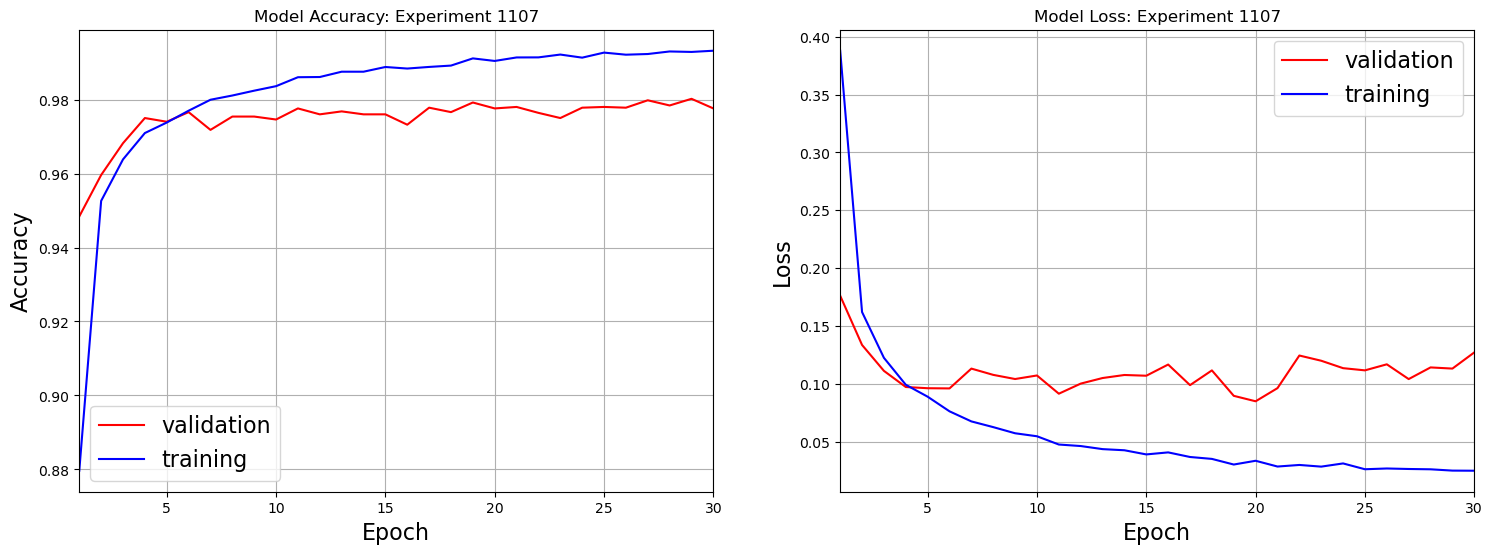

CPU times: total: 14min 51s
Wall time: 1min 17s


In [144]:
%%time
model_ex1107, history_ex1107 = training_wrapper(
    ex_num=1107,
    model=model_ex1107,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (07) Evaluating Trained Model

In [145]:
y_pred_ex1106 = evaluation_wrapper(
    ex_num=1106,
    model=model_ex1106,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1106...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9929
Test Accuracy: 0.9766

Confusion Matrix:
[[ 967    1    1    1    0    2    3    2    3    0]
 [   0 1121    1    4    0    1    2    0    5    1]
 [   2    1 1004    8    1    0    2    6    8    0]
 [   0    0    0  992    0    7    0    4    4    3]
 [   0    0    5    0  962    0    6    0    1    8]
 [   3    0    0   12    0  869    2    1    3    2]
 [   3    3    1    0    6    6  938    0    1    0]
 [   1    3    9    3    0    0    0 1002    1    9]
 [   1    2    2   10    5    8    1    3  940    2]
 [   2    4    0    5   12    4    0    5    6  971]]

***************************************************************************************
**********

### (08) Construct and Compile Model

In [158]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1108 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1108 = tf.keras.optimizers.SGD(0.1)
loss_fn_ex1108 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1108.compile(optimizer=optimizer_ex1108, loss=loss_fn_ex1108, metrics=['accuracy'])

model_ex1108.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                        

### (08) Train Model

Starting Experiment 1108...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 5s 5ms/step - loss: 0.3215 - accuracy: 0.9029 - val_loss: 0.1551 - val_accuracy: 0.9494
Epoch 2/50
860/860 [==============================] - 4s 4ms/step - loss: 0.1592 - accuracy: 0.9513 - val_loss: 0.1144 - val_accuracy: 0.9624
Epoch 3/50
860/860 [==============================] - 4s 4ms/step - loss: 0.1226 - accuracy: 0.9624 - val_loss: 0.1003 - val_accuracy: 0.9688
Epoch 4/50
860/860 [==============================] - 4s 4ms/step - loss: 0.0989 - accuracy: 0.9699 - val_loss: 0.0892 - val_accuracy: 0.9738
Epoch 5/50
860/860 [==============================] - 4s 4ms/step - loss: 0.0851 - accuracy: 0.9732 - val_loss: 0.0988 - val_accuracy: 0.9710


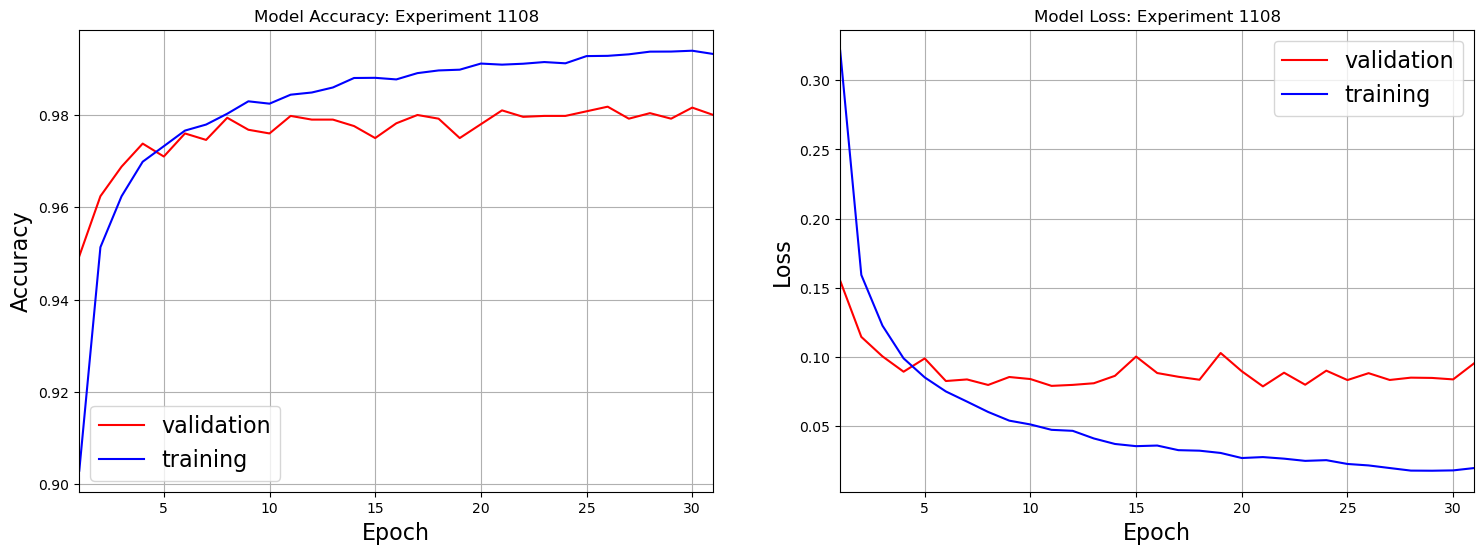

CPU times: total: 20min 59s
Wall time: 1min 52s


In [159]:
%%time
model_ex1108, history_ex1108 = training_wrapper(
    ex_num=1108,
    model=model_ex1108,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

### (08) Evaluating Trained Model

In [160]:
y_pred_ex1108 = evaluation_wrapper(
    ex_num=1108,
    model=model_ex1108,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1108...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9986
Test Accuracy: 0.9824

Confusion Matrix:
[[ 971    0    1    0    1    0    2    1    2    2]
 [   0 1129    0    1    0    0    1    1    3    0]
 [   1    1 1023    2    0    0    0    2    3    0]
 [   1    0    2  993    0    5    0    4    3    2]
 [   0    0    1    1  960    0    2    3    0   15]
 [   3    0    0    9    0  871    1    1    4    3]
 [   4    2    2    1    8    4  934    0    3    0]
 [   0    2    7    1    0    1    0 1010    3    4]
 [   2    1    5    3    3    2    1    4  949    4]
 [   2    2    0    5    7    3    1    5    0  984]]

***************************************************************************************
**********

### (09) Construct and Compile Model

In [ ]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1109 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name='hidden3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name='hidden4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])


optimizer_ex1109 = tf.keras.optimizers.SGD(0.1)
loss_fn_ex1109 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1109.compile(optimizer=optimizer_ex1109, loss=loss_fn_ex1109, metrics=['accuracy'])

model_ex1109.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 100)               78500     
                                                                 
 layer_normalization (LayerN  (None, 100)              200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 300)               30300     
                                                                 
 layer_normalization_1 (Laye  (None, 300)              600       
 rNormalization)                                        

### (09) Train Model

In [162]:
%%time
model_ex1109, history_ex1109 = training_wrapper(
    ex_num=1109,
    model=model_ex1109,
    n_epochs=50,
    batch_size=64,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    cbs=[early_stopping]
)

Starting Experiment 1109...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
860/860 [==============================] - 5s 5ms/step - loss: 0.3124 - accuracy: 0.9049 - val_loss: 0.1570 - val_accuracy: 0.9546
Epoch 2/50
860/860 [==============================] - 5s 5ms/step - loss: 0.1472 - accuracy: 0.9561 - val_loss: 0.1285 - val_accuracy: 0.9604
Epoch 3/50
860/860 [==============================] - 5s 5ms/step - loss: 0.1102 - accuracy: 0.9665 - val_loss: 0.1254 - val_accuracy: 0.9650
Epoch 4/50
860/860 [==============================] - 5s 5ms/step - loss: 0.0895 - accuracy: 0.9726 - val_loss: 0.1164 - val_accuracy: 0.9672
Epoch 5/50
860/860 [==============================] - 5s 5ms/step - loss: 0.0767 - accuracy: 0.9765 - val_loss: 0.1012 - val_accuracy: 0.9738


KeyboardInterrupt: 

### (09) Evaluating Trained Model

In [ ]:
y_pred_ex1109 = evaluation_wrapper(
    ex_num=1108,
    model=model_ex1108,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1108...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9986
Test Accuracy: 0.9824

Confusion Matrix:
[[ 971    0    1    0    1    0    2    1    2    2]
 [   0 1129    0    1    0    0    1    1    3    0]
 [   1    1 1023    2    0    0    0    2    3    0]
 [   1    0    2  993    0    5    0    4    3    2]
 [   0    0    1    1  960    0    2    3    0   15]
 [   3    0    0    9    0  871    1    1    4    3]
 [   4    2    2    1    8    4  934    0    3    0]
 [   0    2    7    1    0    1    0 1010    3    4]
 [   2    1    5    3    3    2    1    4  949    4]
 [   2    2    0    5    7    3    1    5    0  984]]

***************************************************************************************
**********